In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from focal_loss import SparseCategoricalFocalLoss

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.metrics import IoU
from keras import backend as K

### **Actual Work**

In [12]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3

In [13]:
labels = {0:[115, 0, 108], 
          1:[122, 1, 145], 
          2:[148, 47, 216], 
          3:[242, 246, 254], 
          4:[130, 9, 181], 
          5:[157, 85, 236], 
          6:[106, 0, 73], 
          7:[168, 123, 248], 
          8:[0, 0, 0], 
          9:[255, 255, 127], 
          10:[142, 255, 127], 
          11:[127, 127, 255]}

In [ ]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge([cl, a, b])
    result = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return result

In [ ]:
def gamma_correction(image: np.ndarray, gamma):
    gamma_corrected = np.power(image/255.0, gamma)
    gamma_corrected = gamma_corrected*255.0
    gamma_corrected = gamma_corrected.astype(np.uint8)
    return gamma_corrected

In [14]:
def decoded_mask(mask:np.ndarray, labels:dict):
  # mask should be mapped with np.argmax() already
  row, col = mask.shape[0:2]
  b = np.zeros_like(mask) 
  g = np.zeros_like(mask)
  r = np.zeros_like(mask)
  b[b == 0] = 8
  g[g == 0] = 8
  r[r == 0] = 8
  for i in range(row):
    for j in range(col):
      for k, pixel in labels.items():
        if mask[i][j] == k:
          b[i][j] = pixel[0]
          g[i][j] = pixel[1]
          r[i][j] = pixel[2]
  single_mask = np.zeros((row, col, 3), dtype=np.uint8)
  single_mask[:,:,0] = b
  single_mask[:,:,1] = g
  single_mask[:,:,2] = r  

  return single_mask

In [ ]:
def encoded_mask(mask: np.ndarray, labels: dict):
  row, col = mask.shape[0:2]
  b, g, r = mask[:,:,0], mask[:,:,1], mask[:,:,2]
  single_mask = np.zeros_like(b)
  single_mask[single_mask == 0] = 8

  for i in range(row):
    for j in range(col):
      for k, pixel in labels.items():
        if (b[i][j] == pixel[0]) and (g[i][j] == pixel[1]) and (r[i][j] == pixel[2]):
          single_mask[i][j] = k    

  encoded_mask = to_categorical(single_mask, num_classes=len(labels))

  return encoded_mask

In [ ]:
def process_image(path: str, dtype: str): #, labels: dict):
  img = cv2.imread(path)

  if dtype == "/Images/":
    clahe_img = apply_clahe(img)
    g_img = gamma_correction(clahe_img, 2)
    r_img = cv2.resize(g_img, (IMG_WIDTH, IMG_HEIGHT))
    normalized = r_img
  else:
    normalized = encoded_mask(img, labels)

  return normalized

In [ ]:
def process_folder(dir: str, ftype: str, dtype: str): #, labels: dict):
  img = []
  root_dir = "Queensland Dataset CE42" #"/content/Queensland Dataset CE42"
  ldir = os.listdir(root_dir + dir)

  for i, paths in enumerate(ldir):
    if paths.split('.')[1] == 'png':
      try:
        img.append(process_image(root_dir + ftype + dtype + paths, dtype))#, labels)
      except Exception as _:
        print(f"Exception Encountered! at path: {paths}")
        continue
  
  return img

In [ ]:
classes = ["/BCC", "/IEC", "/SCC"]
dataset = ["/Images/", "/Masks/"]
image_dataset = []
mask_dataset = []

for i, datatype in enumerate(dataset):
  for j, obj in enumerate(classes):
    res = process_folder(obj + datatype, obj, datatype) #, labels)
    if datatype == "/Images/":
      image_dataset.append(res)
    else:
      mask_dataset.append(res)

In [ ]:
len(image_dataset), len(mask_dataset)

In [ ]:
image_data = image_dataset[0] + image_dataset[1] + image_dataset[2]
mask_data = mask_dataset[0] + mask_dataset[1] + mask_dataset[2]

------------------------------

#### **Standard Deviation**

In [8]:
# Standard Deviation
np.array(mask_dataset[0]).shape

(256, 256, 12)

In [ ]:
BCC_mask = np.argmax(np.array(mask_dataset[0]), axis=3)
IEC_mask = np.argmax(np.array(mask_dataset[1]), axis=3)
SCC_mask = np.argmax(np.array(mask_dataset[2]), axis=3)

In [ ]:
np.unique(BCC_mask, return_counts=True), np.unique(IEC_mask, return_counts=True), np.unique(SCC_mask, return_counts=True)

In [ ]:
np.std(np.unique(BCC_mask, return_counts=True)[1]), np.std(np.unique(IEC_mask, return_counts=True)[1]), np.std(np.unique(SCC_mask, return_counts=True)[1])

--------------------------------

In [ ]:
image_npdata = np.array(image_data, dtype=np.uint8)
mask_npdata = np.array(mask_data, dtype=np.uint8)

In [ ]:
# save the data
# np.save('./Preprocessed-Data/images.npy', image_npdata)
# np.save('./Preprocessed-Data/mask.npy', mask_npdata)

In [ ]:
image_npdata = np.load('./Preprocessed-Data (includes Zip)/images.npy')
mask_npdata = np.load('./Preprocessed-Data (includes Zip)/mask.npy')

In [ ]:
# Shuffle
X_train, X_test, y_train, y_test = train_test_split(image_npdata, mask_npdata, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### **Model Implementation - Segmentation**

In [15]:
def multi_unet_model(n_classes=12, size=16, kernel_initializer='he_normal',IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=3):

 inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
 #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
 s = inputs

 #Contraction path
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
 #c1 = Dropout(0.1)(c1)
 c1 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
 p1 = MaxPooling2D((2, 2))(c1)
    
 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
 #c2 = Dropout(0.1)(c2)
 c2 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
 p2 = MaxPooling2D((2, 2))(c2)
     
 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
# c3 = Dropout(0.2)(c3)
 c3 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
 p3 = MaxPooling2D((2, 2))(c3)
     
 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
 #c4 = Dropout(0.2)(c4)
 c4 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
 p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
 #c5 = Dropout(0.3)(c5)
 c5 = Conv2D(size * 16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
 c5 = Dropout(0.5)(c5)
    
 #Expansive path 
 u6 = Conv2DTranspose(size * 8, (2, 2), strides=(2, 2), padding='same')(c5)
 u6 = concatenate([u6, c4])
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
 #c6 = Dropout(0.2)(c6)
 c6 = Conv2D(size * 8, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
 u7 = Conv2DTranspose(size * 4, (2, 2), strides=(2, 2), padding='same')(c6)
 u7 = concatenate([u7, c3])
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
 #c7 = Dropout(0.2)(c7)
 c7 = Conv2D(size * 4, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
 u8 = Conv2DTranspose(size * 2, (2, 2), strides=(2, 2), padding='same')(c7)
 u8 = concatenate([u8, c2])
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
 #c8 = Dropout(0.1)(c8)
 c8 = Conv2D(size * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
 u9 = Conv2DTranspose(size * 1, (2, 2), strides=(2, 2), padding='same')(c8)
 u9 = concatenate([u9, c1], axis=3)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
 #c9 = Dropout(0.1)(c9)
 c9 = Conv2D(size * 1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
 outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
 model = Model(inputs=[inputs], outputs=[outputs])

 return model


In [16]:
model = multi_unet_model(n_classes=12,size=64,kernel_initializer='he_normal', IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=COLOR_CHANNELS)

In [17]:
model.compile(optimizer= 'adam', #Adam(lr=1e-3, decay=1e-6),
              loss= SparseCategoricalFocalLoss(gamma=2.0),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Defining callbacks
early_stopping_val_acc = EarlyStopping(monitor='val_accuracy', patience=10,
                                      restore_best_weights=True)
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=10,
                                        restore_best_weights=True)
checkpoint = ModelCheckpoint('Model Chechpoints/model_Q_clahe_70e-10bs_data_adam(1e-5, 0.0001)_sigmoidfocal_2b_0.5a_accuracy.hdf5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=8, verbose=1, mode='max', min_lr=1e-5)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_val_acc,
                               early_stopping_val_loss,
                               checkpoint],
                    shuffle=True)

In [ ]:
# model.save("Model Chechpoints/model_Q_30e-10b_r_data_adam_sigmoidfocal_f1score.hdf5")

------------------

In [18]:
model.load_weights("Kaggle_model\Model_6-Unet64\model64_F_clahe_100e-30bs_MC-vl_data_adam_categoricalcrossentropy_accuracy.hdf5")

In [19]:
Xa_test = np.load('./Preprocessed-Data (includes Zip)/Data-splits/X_test.npy') 
ya_test = np.load('./Preprocessed-Data (includes Zip)/Data-splits/y_test.npy') 

In [20]:
y_pred = model.predict(Xa_test)
y_pred.shape

10/10 [==============================] - 251s 24s/step


(300, 256, 256, 12)

In [21]:
y_preds = np.argmax(y_pred, axis=3)
np.unique(y_preds, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([      3, 1109281,   28621, 2599473, 6454395,  335668,  127943,
         663222, 6938878,  132912,  962970,  307434], dtype=int64))

In [22]:
y_test_c = np.argmax(ya_test, axis=3)
np.unique(y_test_c, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([ 165054,  866429,   47799, 2562508, 6235269,  443330,  120821,
         623224, 7005007,  294810,  935554,  360995], dtype=int64))

In [23]:
for i in range(12):
    IoU_classes = IoU(num_classes=12, target_class_ids=[i])
    IoU_classes.update_state(y_test_c, y_preds)
    print(f'class {i}: {IoU_classes.result().numpy}')

class 0: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.2117173e-05>>
class 1: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.40182123>>
class 2: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.08265095>>
class 3: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.7506228>>
class 4: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.80396664>>
class 5: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.41129985>>
class 6: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.41959414>>
class 7: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.6098545>>
class 8: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.9569725>>
class 9: <bound method _EagerTensorBase.numpy of <tf.Te

In [24]:
index = 29

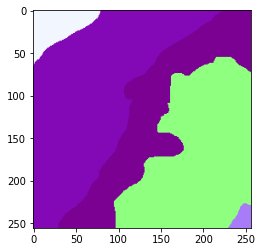

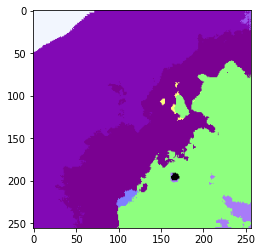

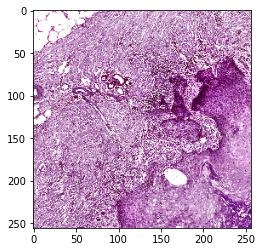

In [25]:
res = decoded_mask(y_test_c[index], labels)
plt.imshow(res)

plt.figure()
res2 = decoded_mask(y_preds[index], labels)
plt.imshow(res2)

plt.figure()
plt.imshow(Xa_test[index])

In [26]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    true_positives = K.sum(y_true_f * y_pred_f)
    false_negatives = K.sum(y_true_f * (1 - y_pred_f))
    false_positives = K.sum((1 - y_true_f) * y_pred_f)
    
    dice = (2.0 * true_positives + smooth) / (2.0 * true_positives + false_positives + false_negatives + smooth)
    
    return dice


In [27]:
dice_coef(np.float32(ya_test), y_pred, smooth=1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8349653>